# Multi-Component 2-D Gaussian Fitting — Tutorial

Dave Mehringer, 2025 September

This notebook demonstrates the major features of:

- `astroviper.distributed.image_analysis.multi_gaussian2d_fit.fit_multi_gaussian2d`
- `astroviper.distributed.image_analysis.multi_gaussian2d_fit.plot_components` (if available)

You’ll learn how to:
- Fit one or many 2-D Gaussians (sum of components) to images or data cubes
- Use NumPy, Dask, or Xarray inputs and vectorize over extra dims
- Provide initial guesses (array / list-of-dicts / dict-with-components)
- Apply bounds (including fixing parameters with equal bounds)
- Use thresholds to mask pixels during the fit
- Work with angle conventions: `"math"`, `"pa"`, and `"auto"`
- Get world coordinates of centroids when axis coords are provided
- Return fitted model plane(s) and residuals

**Tip:** Run cells top-to-bottom. All cells are self-contained and documented.

## Imports & Utilities

In [1]:
import numpy as np
import xarray as xr
import dask
import dask.array as da
import matplotlib.pyplot as plt

from astroviper.distributed.image_analysis.multi_gaussian2d_fit import (
    fit_multi_gaussian2d, plot_components
)
from astroviper.distributed.model.component_models import make_gauss2d

from astroviper.distributed.image_analysis.selection import (
    select_mask
)

#from astroviper.utils.plotting import plot_correct_orientation

# Reproducibility
rng = np.random.default_rng(1234)

### Utility: synthetic Gaussian scenes
Helpers used only to generate synthetic test images for this tutorial.

In [2]:
def make_scene_via_component_models(
    ny: int,
    nx: int,
    components: list[dict],
    *,
    offset: float = 0.1,
    noise_std: float = 0.02,
    seed: int | None = None,
    coords: bool = True,
    angle: str = "math",  # "math" | "pa" | "auto" — same semantics as astroviper's model
    x_world: tuple[float, float] = (0.0, 1.0),
    y_world: tuple[float, float] = (0.0, 1.0),
) -> xr.DataArray:
    """
    Build a synthetic image using astroviper.model.component_models.(make_gaussian|make_gauss2d).

    components: list of dicts with keys:
      {"amp"/"amplitude","x0","y0","sigma_x","sigma_y","theta"}.
    """
    rng = np.random.default_rng(seed)

    nchan = 1 if isinstance(components[0], dict) else len(components)
    
    # coords
    if coords:
        x0, x1 = x_world
        y0, y1 = y_world
        x = np.linspace(x0, x1, nx, dtype=float)
        y = np.linspace(y0, y1, ny, dtype=float)
    else:
        x = np.arange(nx, dtype=float)
        y = np.arange(ny, dtype=float)
    # accumulate model in float64
    if nchan == 1:
        components = [components.copy()]
    z = np.zeros((ny, nx, nchan), dtype=float)
    print("components", components, type(components))
    for i in range(nchan):
        plane_components = components[i]
        for c in plane_components:
            print("plane component", c, type(c))
            amp = float(c.get("amp", c.get("amplitude")))
            x0c = float(c["x0"])
            y0c = float(c["y0"])
            fwhm_x = float(c["fwhm_major"])
            fwhm_y = float(c["fwhm_minor"])
            thc = float(c.get("theta", 0.0))

            # astroviper's generator uses coords + angle convention, returns (ny,nx)
            z[:,:,i] = make_gauss2d(
                data=z[..., i],
                a=fwhm_x,
                b=fwhm_y,
                theta=thc,
                x0=x0c,
                y0=y0c,
                peak=amp,
                x_coord="x",
                y_coord="y",
                coords={"x": x, "y": y},
                add=True,
                angle=angle,
            )
    if nchan == 1:
        z = np.squeeze(z, axis=2)

    z += float(offset)
    if noise_std > 0:
        z += rng.normal(scale=noise_std, size=z.shape)

    dims = ("y", "x") if nchan == 1 else ("y", "x", "z")
    print("shape z", z.shape, "dims", dims)
    da = xr.DataArray(z, dims=dims)
    print("da shape", da.shape)
    if coords:
        vals = dict(x=x, y=y) if nchan == 1 else dict(x=x, y=y, z=np.array((2, 4), dtype=float))
        da = da.assign_coords(vals)
    return da

### Get array min/max

In [3]:
def minmax(a, dim=None, skipna=True, compute=True):
    """
    Return (vmin, vmax) for NumPy ndarray, Dask array, or xarray.DataArray.

    Parameters
    ----------
    a : np.ndarray | dask.array.Array | xarray.DataArray
    dim : axis or sequence of axes (NumPy/Dask) or dim name(s) (xarray)
    skipna : bool
        If True, ignore NaNs (uses nanmin/nanmax where appropriate).
    compute : bool
        If True, trigger computation for Dask/xarray and return concrete results.
        If False, return lazy objects (Dask arrays or xarray objects).

    Notes
    -----
    - For xarray, dim should be a dimension name or list/tuple of names.
    - For NumPy/Dask, dim is passed to the `axis` argument (can be int or tuple).
    """
    # xarray.DataArray (NumPy- or Dask-backed)
    if isinstance(a, xr.DataArray):
        vmin = a.min(dim=dim, skipna=skipna)
        vmax = a.max(dim=dim, skipna=skipna)
        if compute:
            # apparently newer xarray versions have implemented compute()
            xr_compute = getattr(xr, "compute", None)
            if xr_compute is not None:
                vmin, vmax = xr_compute(vmin, vmax)  # shared graph → one chunk read
        return vmin.item(), vmax.item()

    # Dask array
    if isinstance(a, da.Array):
        if skipna:
            vmin = da.nanmin(a, axis=dim)
            vmax = da.nanmax(a, axis=dim)
        else:
            vmin = da.min(a, axis=dim)
            vmax = da.max(a, axis=dim)
        if compute:
            vmin, vmax = da.compute(vmin, vmax)  # compute together
        return vmin, vmax

    # Fallback: treat as NumPy array
    a = np.asarray(a)
    if skipna and np.issubdtype(a.dtype, np.floating):
        vmin = np.nanmin(a, axis=dim)
        vmax = np.nanmax(a, axis=dim)
    else:
        vmin = np.min(a, axis=dim)
        vmax = np.max(a, axis=dim)
    return vmin, vmax


In [4]:
def _decimals_from_err(err, sig=2):
    e = np.asarray(err, dtype=float)
    out = np.empty(e.shape, dtype=int)
    mask = np.isfinite(e) & (e != 0)
    exp = np.floor(np.log10(np.abs(e[mask]))).astype(int)
    out[mask] = -(exp) + (sig - 1)   # decimals to show sig significant digits
    out[~mask] = sig                 # fallback for zero/inf/nan
    return out

def _round_by_decimals(a, nd):
    a = np.asarray(a, dtype=float)
    nd = np.asarray(nd, dtype=int)
    if nd.ndim == 0:
        return np.round(a, int(nd))
    nd = np.broadcast_to(nd, a.shape)
    v = np.vectorize(lambda x, n: np.round(x, int(n)), otypes=[float])
    return v(a, nd)

def round_for_display(values, errors, sig=2, as_string=True):
    v = np.asarray(values, dtype=float)
    e = np.asarray(errors, dtype=float)

    nd = _decimals_from_err(e, sig=sig)  # per-item decimals
    er = _round_by_decimals(e, nd)
    vr = _round_by_decimals(v, nd)

    if not as_string:
        return vr, er

    dprint = np.maximum(nd, 0)  # negative -> show 0 decimals when printing
    fmt = np.vectorize(lambda x, d: f"{x:.{int(d)}f}", otypes=[str])
    v_str = fmt(vr, dprint)
    e_str = fmt(er, dprint)
    return v_str, e_str

# demo
vals = np.array([6.5741428, 4.56483369])
errs = np.array([0.15614591, 0.07569871])
v_str, e_str = round_for_display(vals, errs, sig=2, as_string=True)
print(f"[{', '.join(v_str)}] +/- [{', '.join(e_str)}]")
# -> [6.57, 4.565] +/- [0.16, 0.076]


[6.57, 4.565] +/- [0.16, 0.076]


## Getting your feet wet. Just supplying the data and the number of desired components to be fit.

### Fit a single Gaussian in noiseless image to prove functionality

#### Create the model to be fit

Here we create a single gaussian model. The image we pass to the fitter is noiseless; this is
a basic example that demonstrates the minimum functionality.

In [5]:
# size of image
nx = 129
ny = 129

# model componenet
comp_1g = [
    dict(amp=5.0, x0=40, y0=-20, fwhm_major=20.0, fwhm_minor=10.0, theta=0.4)
]

data_1g = make_scene_via_component_models(
    ny=ny,
    nx=nx,
    components=comp_1g,
    offset=0.0,
    noise_std=0,
    x_world=(-nx+1, nx-1),
    y_world=(-ny+1, ny-1),
)

print("type of returned data", type(data_1g))

components [[{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}]] <class 'list'>
plane component {'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4} <class 'dict'>
shape z (129, 129) dims ('y', 'x')
da shape (129, 129)
type of returned data <class 'xarray.core.dataarray.DataArray'>


#### Perform the fit

Feed the image the data. You can supply an initial guess to provide a starting point, but its
not required. It is generally advisable to supply an initial guess for low S/N or multiple 
componenets. Here we are doing the minimum. In cases of blended components an initial guess
will almost certainly have to be supplied. We will simply pass in the data and specify we
want one Gaussian to be fit. The application will make an initial guess itself if we
don't supply one.

The output is an xr.Dataset with the data variables holding the fit parameters. The
parameters are self-documenting; each contains a "description" attr explaining what it
represents. Applicable parameters have fit values in both pixel and world (if specified)
coordinates. There are Dataset attrs as well. One is **fit_native_frame**, which
indicates in which coordinate system, pixel or world, the fit was actually performed.

The fit parameters should be equal to those in the model, with perhaps differences of
the order of machine precision.

In [6]:
print("the model we are fitting is", comp_1g)

# preform the fit.
fit_1g = fit_multi_gaussian2d(data_1g, n_components=1)
fit_1g

the model we are fitting is [{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}]


<xarray.Dataset> Size: 135kB
Dimensions:                (component: 1, x: 129, y: 129)
Coordinates:
  * x                      (x) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
  * y                      (y) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
Dimensions without coordinates: component
Data variables: (12/37)
    amplitude              (component) float64 8B 5.0
    amplitude_err          (component) float64 8B 4.332e-16
    peak                   (component) float64 8B 5.0
    peak_err               (component) float64 8B 4.334e-16
    x0_pixel               (component) float64 8B 84.0
    y0_pixel               (component) float64 8B 54.0
    ...                     ...
    variance_explained     float64 8B 1.0
    residual               (y, x) float64 133kB -4.543e-17 ... -4.543e-17
    x0_world               (component) float64 8B 40.0
    y0_world               (component) float64 8B -20.0
    x0_world_err           (component) float64 8B 6.927e-16
    y0_world_err           (component) float64 8B 4.438e-16
Attributes:
    axes_handedness:   right
    theta_convention:  math
    call:              fit_multi_gaussian2d(...)
    param:             {'n_components': 1, 'dims': None, 'min_threshold': Non...
    package:           astroviper
    version:           0.0.18
    fit_native_frame:  world

#### Interrogate the residual image and plot the data

By default, the returned Dataset contains the fit residuaul image. In our case
the residual image should be zero, for all intents and purposes. To confirm,
we can find its min and max values. Both should be of order 1e-14; essentially
0. We can plot data and the residual side by side using the plot_components()
function. The overlaid ellipse represents the fit FWHM of the associated component.


residual min, max:  (-1.1102230246251565e-14, 3.419486915845482e-14)


(<Figure size 1200x500 with 2 Axes>,
 (<Axes: title={'center': 'Data with fitted components'}, xlabel='x', ylabel='y'>,
  <Axes: title={'center': 'Residual (data − model)'}, xlabel='x', ylabel='y'>))

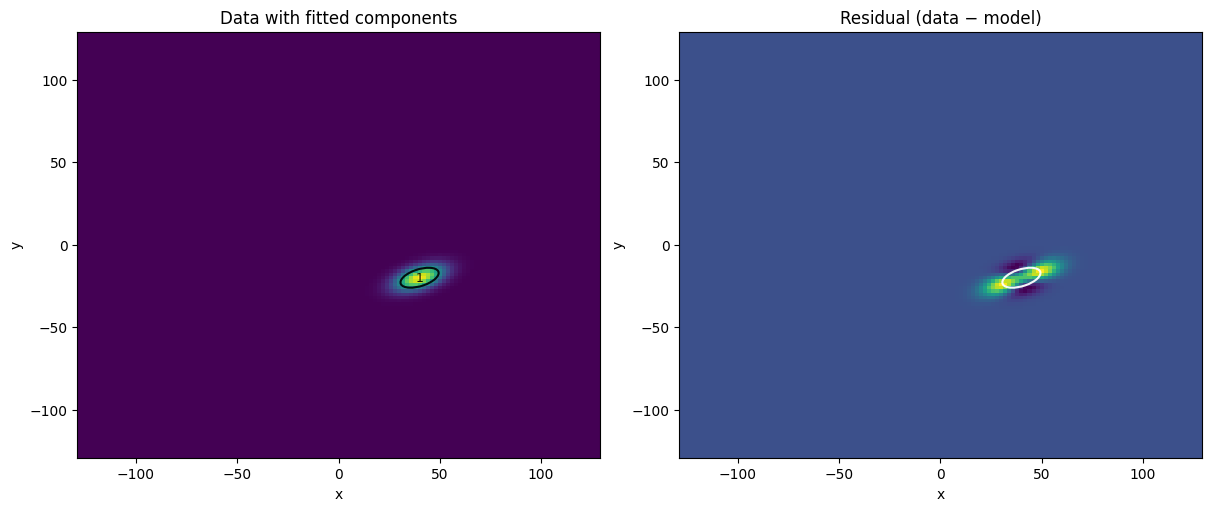

In [7]:
resid_1g = fit_1g["residual"]
print("residual min, max: ", minmax(resid_1g))
plot_components(data_1g, fit_1g, dims=("x", "y"), show_residual=True, fwhm=True)

### Two Gaussians in noiseless image

Let's add another componenet and fit two Gaussians simultaneously. We don't supply an
initial guess, so the application will determine initial guesses.

In [8]:
comp_2g = comp_1g.copy()
comp_2g.append(dict(amp=7.0, x0=-50, y0=10, fwhm_major=8.0, fwhm_minor=6.0, theta=1))

data_2g = make_scene_via_component_models(
    ny=ny,
    nx=nx,
    components=comp_2g,
    offset=0.0,
    noise_std=0,
    x_world=(-nx+1, nx-1),
    y_world=(-ny+1, ny-1),
)

components [[{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}]] <class 'list'>
plane component {'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4} <class 'dict'>
plane component {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1} <class 'dict'>
shape z (129, 129) dims ('y', 'x')
da shape (129, 129)


In [9]:
print("the model we are fitting is", comp_2g)

# preform the fit.
fit_2g = fit_multi_gaussian2d(data_2g, n_components=2)
fit_2g

the model we are fitting is [{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}]


<xarray.Dataset> Size: 136kB
Dimensions:                (component: 2, x: 129, y: 129)
Coordinates:
  * x                      (x) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
  * y                      (y) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
Dimensions without coordinates: component
Data variables: (12/37)
    amplitude              (component) float64 16B 7.0 5.0
    amplitude_err          (component) float64 16B 5.325e-16 2.609e-16
    peak                   (component) float64 16B 7.0 5.0
    peak_err               (component) float64 16B 5.325e-16 2.61e-16
    x0_pixel               (component) float64 16B 39.0 84.0
    y0_pixel               (component) float64 16B 69.0 54.0
    ...                     ...
    variance_explained     float64 8B 1.0
    residual               (y, x) float64 133kB -5.244e-18 ... -5.244e-18
    x0_world               (component) float64 16B -50.0 40.0
    y0_world               (component) float64 16B 10.0 -20.0
    x0_world_err           (component) float64 16B 2.147e-16 4.171e-16
    y0_world_err           (component) float64 16B 2.414e-16 2.672e-16
Attributes:
    axes_handedness:   right
    theta_convention:  math
    call:              fit_multi_gaussian2d(...)
    param:             {'n_components': 2, 'dims': None, 'min_threshold': Non...
    package:           astroviper
    version:           0.0.18
    fit_native_frame:  world

The min/max residual values should be on the order of 1e-14.

residual min, max:  (-2.9753977059954195e-14, 4.04121180963557e-14)


(<Figure size 1200x500 with 2 Axes>,
 (<Axes: title={'center': 'Data with fitted components'}, xlabel='x', ylabel='y'>,
  <Axes: title={'center': 'Residual (data − model)'}, xlabel='x', ylabel='y'>))

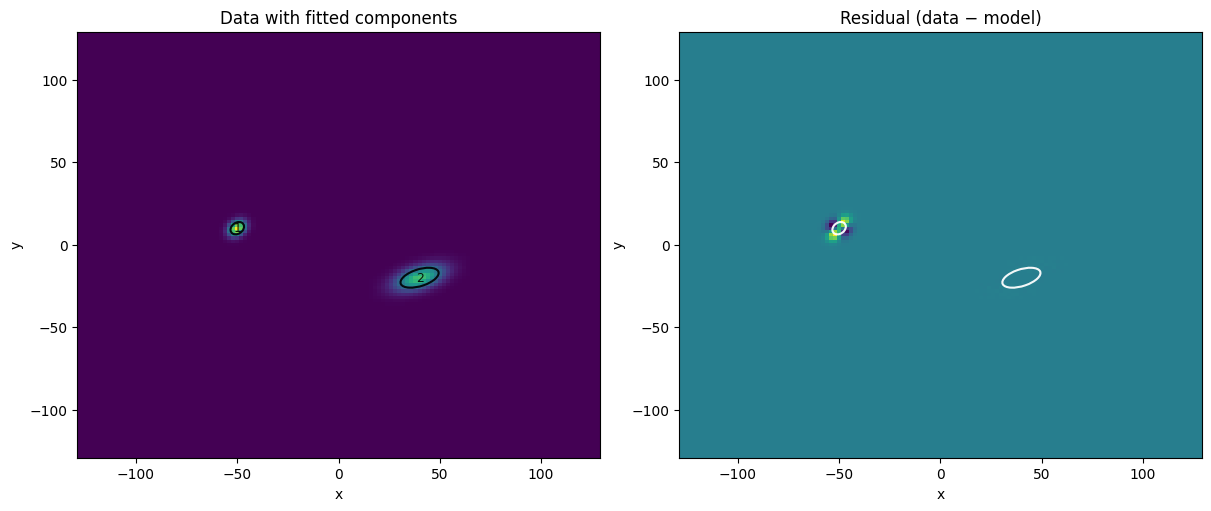

In [10]:
print("residual min, max: ", minmax(fit_2g["residual"]))
plot_components(data_2g, fit_2g, dims=("x", "y"), show_residual=True, fwhm=True)

### Fitting with noise

Now let's add some noise and fit wo the uncertainties will be more interesting

In [11]:
data_2g_noise = make_scene_via_component_models(
    ny=ny,
    nx=nx,
    components=comp_2g,
    offset=0.0,
    noise_std=0.5,
    x_world=(-nx+1, nx-1),
    y_world=(-ny+1, ny-1),
)

noise_reg = data_2g_noise[:, 0:32]
std = noise_reg.std().item()

print("noise level", std)
print("noise min, max", minmax(noise_reg))

components [[{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}]] <class 'list'>
plane component {'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4} <class 'dict'>
plane component {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1} <class 'dict'>
shape z (129, 129) dims ('y', 'x')
da shape (129, 129)
noise level 0.498319535682792
noise min, max (-2.126135973600686, 1.6737579346216627)


In [12]:
print("the model we are fitting is", comp_2g)

# preform the fit.
fit_2g_noise = fit_multi_gaussian2d(data_2g_noise, n_components=2)
fit_2g_noise

the model we are fitting is [{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}]


<xarray.Dataset> Size: 136kB
Dimensions:                (component: 2, x: 129, y: 129)
Coordinates:
  * x                      (x) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
  * y                      (y) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
Dimensions without coordinates: component
Data variables: (12/37)
    amplitude              (component) float64 16B 7.584 5.008
    amplitude_err          (component) float64 16B 0.2818 0.132
    peak                   (component) float64 16B 7.585 5.009
    peak_err               (component) float64 16B 0.2819 0.1321
    x0_pixel               (component) float64 16B 38.93 83.93
    y0_pixel               (component) float64 16B 69.04 53.96
    ...                     ...
    variance_explained     float64 8B 0.2051
    residual               (y, x) float64 133kB -0.02194 0.05123 ... 0.2547
    x0_world               (component) float64 16B -50.13 39.86
    y0_world               (component) float64 16B 10.08 -20.07
    x0_world_err           (component) float64 16B 0.1014 0.2114
    y0_world_err           (component) float64 16B 0.1109 0.1356
Attributes:
    axes_handedness:   right
    theta_convention:  math
    call:              fit_multi_gaussian2d(...)
    param:             {'n_components': 2, 'dims': None, 'min_threshold': Non...
    package:           astroviper
    version:           0.0.18
    fit_native_frame:  world

residual min, max:  (-2.1273757493022023, 1.9811346157519782)


(<Figure size 1200x500 with 2 Axes>,
 (<Axes: title={'center': 'Data with fitted components'}, xlabel='x', ylabel='y'>,
  <Axes: title={'center': 'Residual (data − model)'}, xlabel='x', ylabel='y'>))

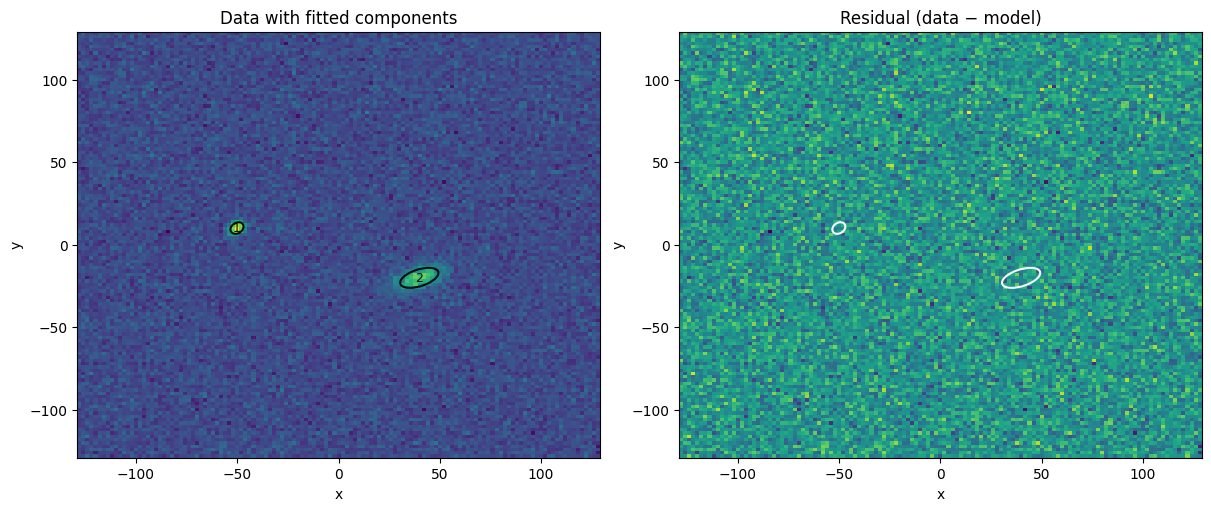

In [13]:
print("residual min, max: ", minmax(fit_2g_noise["residual"]))
plot_components(data_2g_noise, fit_2g_noise, dims=("x", "y"), show_residual=True, fwhm=True)

### Fitting over multiple planes

One can simultaneously fit each plane of a >2D image, if all planes have the same number of components to fit. Here we simultaneously fit to both planes of an array with shape (nx, ny, 2).

In [14]:
plane_0_model = comp_2g.copy()
plane_1_model = [
    dict(amp=7.0, x0=-70, y0=-30, fwhm_major=20.0, fwhm_minor=15.0, theta=0.5),
    dict(amp=11.0, x0=28, y0=15.5, fwhm_major=15.6, fwhm_minor=10.0, theta=1.2)
]

comp_2p = (plane_0_model, plane_1_model)

data_2p = make_scene_via_component_models(
    ny=ny,
    nx=nx,
    components=comp_2p,
    offset=0.0,
    noise_std=0.5,
    x_world=(-nx+1, nx-1),
    y_world=(-ny+1, ny-1),
)

components ([{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}], [{'amp': 7.0, 'x0': -70, 'y0': -30, 'fwhm_major': 20.0, 'fwhm_minor': 15.0, 'theta': 0.5}, {'amp': 11.0, 'x0': 28, 'y0': 15.5, 'fwhm_major': 15.6, 'fwhm_minor': 10.0, 'theta': 1.2}]) <class 'tuple'>
plane component {'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4} <class 'dict'>
plane component {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1} <class 'dict'>
plane component {'amp': 7.0, 'x0': -70, 'y0': -30, 'fwhm_major': 20.0, 'fwhm_minor': 15.0, 'theta': 0.5} <class 'dict'>
plane component {'amp': 11.0, 'x0': 28, 'y0': 15.5, 'fwhm_major': 15.6, 'fwhm_minor': 10.0, 'theta': 1.2} <class 'dict'>
shape z (129, 129, 2) dims ('y', 'x', 'z')
da shape (129, 129, 2)


In [15]:
print("the model we are fitting is", comp_2p)

# preform the fit.
fit_2p = fit_multi_gaussian2d(data_2p, n_components=2)
fit_2p

the model we are fitting is ([{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}], [{'amp': 7.0, 'x0': -70, 'y0': -30, 'fwhm_major': 20.0, 'fwhm_minor': 15.0, 'theta': 0.5}, {'amp': 11.0, 'x0': 28, 'y0': 15.5, 'fwhm_major': 15.6, 'fwhm_minor': 10.0, 'theta': 1.2}])


<xarray.Dataset> Size: 269kB
Dimensions:                (z: 2, component: 2, x: 129, y: 129)
Coordinates:
  * z                      (z) float64 16B 2.0 4.0
  * x                      (x) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
  * y                      (y) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
Dimensions without coordinates: component
Data variables: (12/37)
    amplitude              (z, component) float64 32B 6.984 5.073 11.11 7.0
    amplitude_err          (z, component) float64 32B 0.2672 0.1344 ... 0.1105
    peak                   (z, component) float64 32B 6.981 5.07 11.12 7.005
    peak_err               (z, component) float64 32B 0.2672 0.1345 ... 0.1106
    x0_pixel               (z, component) float64 32B 38.98 84.23 77.99 28.94
    y0_pixel               (z, component) float64 32B 69.05 54.17 71.77 48.94
    ...                     ...
    variance_explained     (z) float64 16B 0.201 0.5244
    residual               (z, y, x) float64 266kB 0.2419 -0.8835 ... -0.2741
    x0_world               (z, component) float64 32B -50.04 40.46 27.98 -70.12
    y0_world               (z, component) float64 32B 10.09 -19.65 15.54 -30.12
    x0_world_err           (z, component) float64 32B 0.1092 0.2067 ... 0.1284
    y0_world_err           (z, component) float64 32B 0.123 0.1359 ... 0.1064
Attributes:
    axes_handedness:   right
    theta_convention:  math
    call:              fit_multi_gaussian2d(...)
    param:             {'n_components': 2, 'dims': None, 'min_threshold': Non...
    package:           astroviper
    version:           0.0.18
    fit_native_frame:  world

Plot both planes using the **indexer** param to indicate which plane to plot.

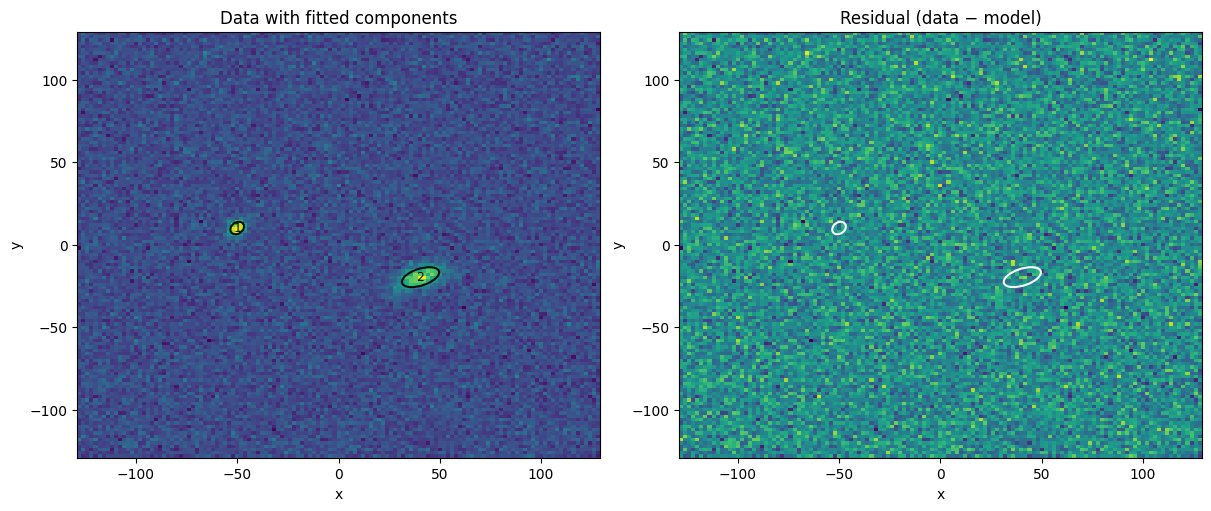

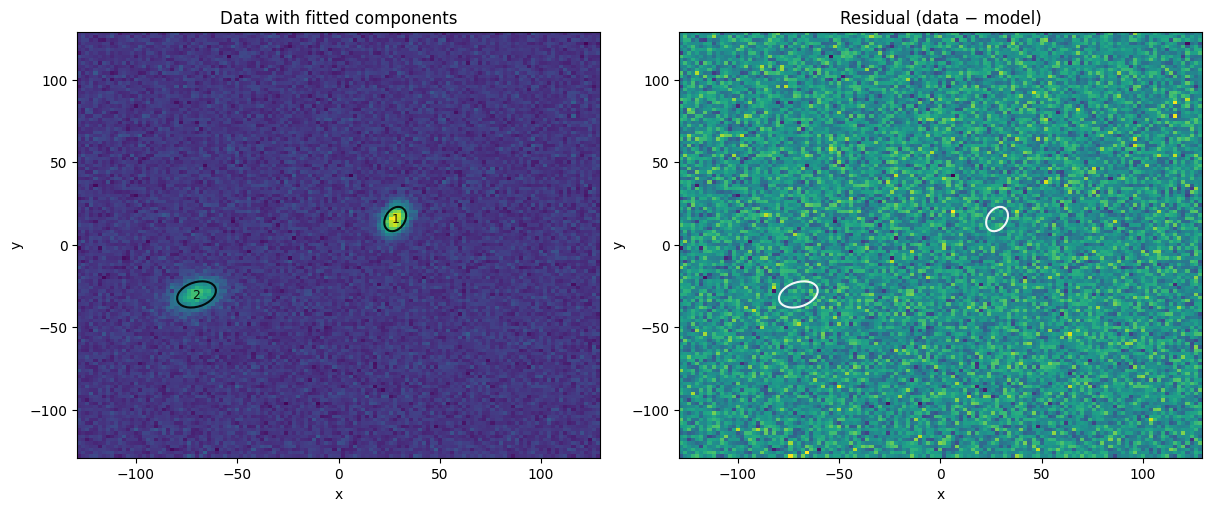

In [16]:
plot_components(data_2p, fit_2p, dims=("x", "y"), show_residual=True, fwhm=True, indexer=dict(z=0))
junk=plot_components(data_2p, fit_2p, dims=("x", "y"), show_residual=True, fwhm=True, indexer=dict(z=1))

## Threshold masking
The application supports thresholding, so that pixels outside inclusive `[min_threshold, max_threshold]` are ignored during the fit.

In [17]:
print("We are fitting to thess models:", comp_2g)
fit_thr = fit_multi_gaussian2d(
    data_2g_noise, n_components=2, min_threshold=0.4, max_threshold=None
)
print(f"\n{"Comparison of thresholded vs non-thresholded fits".upper():^100}")
print(f"{"Results with threshold":>42} \t\tResults without threshold\n")
for k in (
    "amplitude", "peak", "offset", "x0_world", "y0_world",
    "fwhm_major_world", "fwhm_minor_world", "theta_world"
):
    v, e = round_for_display(
        fit_thr[k].values, fit_thr[k+"_err"].values, sig=2, as_string=False
    )
    v1, e1 = round_for_display(
        fit_2g_noise[k].values, fit_2g_noise[k+"_err"].values, sig=2, as_string=False
    )
    print(f"{k:<18}{str(v):>18} \u00B1 {str(e):<13} {str(v1):>18} \u00B1 {str(e1):<20}")
print(
    "\nNote that the offset is signiificantly higher in the thresholded fit "
    "because of the omission of lower values"
)
fit_thr

We are fitting to thess models: [{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}]

                         COMPARISON OF THRESHOLDED VS NON-THRESHOLDED FITS                          
                    Results with threshold 		Results without threshold

amplitude              [6.98  4.555] ± [0.16  0.078]        [7.58 5.01] ± [0.28 0.13]         
peak                   [7.66  5.235] ± [0.16  0.078]        [7.59 5.01] ± [0.28 0.13]         
offset                        0.6802 ± 0.0041                    0.0012 ± 0.0039              
x0_world           [-50.105  40.02 ] ± [0.055 0.11 ]    [-50.13  39.86] ± [0.1  0.21]         
y0_world           [ 10.174 -20.015] ± [0.061 0.074]    [ 10.08 -20.07] ± [0.11 0.14]         
fwhm_major_world       [ 6.84 16.87] ± [0.16 0.29]        [ 7.57 20.13] ± [0.28 0.53]         
fwhm_minor_world         [5.36 8.43] ± [0.12 0.15

<xarray.Dataset> Size: 136kB
Dimensions:                (component: 2, x: 129, y: 129)
Coordinates:
  * x                      (x) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
  * y                      (y) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
Dimensions without coordinates: component
Data variables: (12/37)
    amplitude              (component) float64 16B 6.98 4.555
    amplitude_err          (component) float64 16B 0.1552 0.07828
    peak                   (component) float64 16B 7.66 5.235
    peak_err               (component) float64 16B 0.1553 0.07839
    x0_pixel               (component) float64 16B 38.95 84.01
    y0_pixel               (component) float64 16B 69.09 53.99
    ...                     ...
    variance_explained     float64 8B 0.7476
    residual               (y, x) float64 133kB -0.7009 -0.6277 ... -0.4242
    x0_world               (component) float64 16B -50.11 40.02
    y0_world               (component) float64 16B 10.17 -20.01
    x0_world_err           (component) float64 16B 0.05454 0.115
    y0_world_err           (component) float64 16B 0.06065 0.07435
Attributes:
    axes_handedness:   right
    theta_convention:  math
    call:              fit_multi_gaussian2d(...)
    param:             {'n_components': 2, 'dims': None, 'min_threshold': 0.4...
    package:           astroviper
    version:           0.0.18
    fit_native_frame:  world

## Initial guesses formats
Forms:
- **Array (N,6)** — used above.
- **List of N dicts** — supports key synonyms.
- **Dict with `"components"`** — optional `"offset"` seed.
Angles in `initial_guesses` are interpreted per `angle=`.

In [18]:
# print("We are fitting to these models: ", comp_2g)

# (a) array(N, 6).
# The order is [amplitude, x0, y0, fwhm_major, fwhm_minor, theta]
init_arr = [
    [5.5, 41.0, -22.5, 15.0, 8.0, 0.3],
    [8.5, -56.0, 8.5, 6.0, 4.5, 0.9],
]
ds_arr = fit_multi_gaussian2d(data_2g_noise, n_components=2, initial_guesses=init_arr)


# (b) list of dicts
init_list = [
    {"amp": 5.5, "x0": 41.0, "y0": -22.5, "fwhm_major": 15.0, "fwhm_minor": 8.0, "theta": 0.3},
    {"amplitude": 8.5, "x0": -56.0, "y0": 8.5, "sx": 7.0, "sy": 5.2, "theta": 0.9},
]
ds_list = fit_multi_gaussian2d(data_2g_noise, n_components=2, initial_guesses=init_list)

# (c) dict with 'components' and 'offset'
init_dict = {"offset": 0.12, "components": init_arr}
ds_dict = fit_multi_gaussian2d(data_2g_noise, n_components=2, initial_guesses=init_dict)

None

In [19]:
print("We are fitting to these models: ", comp_2g)

title = "COMPARISON OF RESULTS FOR THE THREE FORMATS"
keys = (
    "amplitude", "peak", "offset", "x0_world", "y0_world",
    "fwhm_major_world", "fwhm_minor_world", "theta_world"
)

def _fmt_cell(key, val):
    a = np.asarray(val)
    if key == "offset":
        if a.shape == () or a.size == 1:
            return f"{a.astype(float).item():.4f}"
        return "[" + ", ".join(f"{x:.2f}" for x in a.ravel()) + "]"
    return "[" + ", ".join(f"{x:.2f}" for x in a.ravel()) + "]"

rows = []
for k in keys:
    rows.append((
        k,
        _fmt_cell(k, ds_arr[k]),
        _fmt_cell(k, ds_list[k]),
        _fmt_cell(k, ds_dict[k]),
    ))

headers = ("Variable", "Array", "List", "Dict")
w0 = max(len(headers[0]), max(len(r[0]) for r in rows))
w1 = max(len(headers[1]), max(len(r[1]) for r in rows))
w2 = max(len(headers[2]), max(len(r[2]) for r in rows))
w3 = max(len(headers[3]), max(len(r[3]) for r in rows))

sep = f"+-{'-'*w0}-+-{'-'*w1}-+-{'-'*w2}-+-{'-'*w3}-+"
header = f"| {headers[0]:<{w0}} | {headers[1]:<{w1}} | {headers[2]:<{w2}} | {headers[3]:<{w3}} |"

total_width = len(sep)
print("\n" + title.center(total_width) + "\n")
print(sep)
print(header)
print(sep)
for k, c1, c2, c3 in rows:
    print(f"| {k:<{w0}} | {c1:<{w1}} | {c2:<{w2}} | {c3:<{w3}} |")
print(sep)

We are fitting to these models:  [{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}]

               COMPARISON OF RESULTS FOR THE THREE FORMATS                

+------------------+-----------------+-----------------+-----------------+
| Variable         | Array           | List            | Dict            |
+------------------+-----------------+-----------------+-----------------+
| amplitude        | [5.01, 7.58]    | [5.01, 7.58]    | [5.01, 7.58]    |
| peak             | [5.01, 7.59]    | [5.01, 7.59]    | [5.01, 7.59]    |
| offset           | 0.0012          | 0.0012          | 0.0012          |
| x0_world         | [39.86, -50.13] | [39.86, -50.13] | [39.86, -50.13] |
| y0_world         | [-20.07, 10.08] | [-20.07, 10.08] | [-20.07, 10.08] |
| fwhm_major_world | [20.13, 7.57]   | [20.13, 7.57]   | [20.13, 7.57]   |
| fwhm_minor_world | [9.90, 5.78]    | [

# Mask-aware 2D Multi-Gaussian Fitting — Mini Tutorial

## What you’ll learn:
### - Fit without a mask (baseline).
### - Fit with a boolean `(y, x)` mask (exclude regions/pixels).
### - Fit with an **OTF string mask** (delegates to `selection.select_mask`).
### - Broadcast a `(y, x)` mask across a stacked cube (e.g., time).
### - Combine mask with `min_threshold` / `max_threshold`.
### - Handle errors when masking removes all usable pixels.

In [20]:

def _resolve_mask_for_image(
    img_da: xr.DataArray,
    mask: xr.DataArray | np.ndarray | str | None,
) -> xr.DataArray | None:
    """
    Resolve `mask` into a boolean xarray.DataArray aligned to `img_da`.
    Accepts:
      - None → returns None
      - np.ndarray / xr.DataArray (bool)
      - str → delegates to selection.select_mask(img_da, mask_spec)

    Returns:
      xr.DataArray with dtype=bool and same (y,x) shape as `img_da`, or None.
    """
    if mask is None:
        return None

    if isinstance(mask, str):
        res = select_mask(img_da, mask)  # project-specific OTF parser
    else:
        res = mask

    # Normalize to DataArray
    if isinstance(res, xr.Dataset):
        if "mask" not in res:
            raise TypeError("selection.select_mask returned a Dataset without a 'mask' variable.")
        res = res["mask"]

    if isinstance(res, np.ndarray):
        # If 2-D, assume (y, x); otherwise assume same dims as img_da
        if res.ndim == 2 and {"y", "x"}.issubset(set(img_da.dims)):
            res = xr.DataArray(res, dims=("y", "x"))
        else:
            res = xr.DataArray(res, dims=img_da.dims)

    if not isinstance(res, xr.DataArray):
        raise TypeError("Mask must resolve to an xarray.DataArray, numpy.ndarray, or Dataset with 'mask'.")

    # Align to image and cast to bool
    res = res.astype(bool)
    res, _ = xr.align(res, img_da, join="right")

    # If there are extra leading dims, try to collapse them with any/all to a (y,x) mask for display
    lead_dims = [d for d in res.dims if d not in ("y", "x")]
    if lead_dims:
        # Keep a pixel if ALL leading dims keep it (conservative for visualization)
        res = res.all(dim=lead_dims)

    # Now ensure it's exactly (y,x) for plotting
    if set(res.dims) != {"y", "x"}:
        res = res.transpose("y", "x")

    return res

# Small helper to visualize an image + mask
def show_image_and_mask(
    img_da: xr.DataArray,
    mask: xr.DataArray | np.ndarray | str | None = None,
    title: str = "",
    *,
    masked_out_alpha: float = 0.35,
    masked_out_rgb: tuple[float, float, float] = (0.0, 0.0, 0.0),  # black tint
) -> xr.DataArray | None:
    """
    Plot `img_da` and optionally overlay a mask contour.
    `mask` can be:
      - None
      - boolean ndarray/DataArray
      - string OTF spec → resolved via selection.select_mask(img_da, spec)

    Returns:
      The resolved mask (DataArray) or None.
    """
    mda = _resolve_mask_for_image(img_da, mask)

    fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.0))
    ax.imshow(np.asarray(img_da), origin="lower", interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    if mda is not None:
        m = np.asarray(mda, dtype=bool)

        # RGBA overlay: tint masked-out pixels with a translucent layer
        overlay = np.zeros(m.shape + (4,), dtype=float)
        overlay[~m, :3] = masked_out_rgb
        overlay[~m, 3] = masked_out_alpha
        ax.imshow(overlay, origin="lower", interpolation="nearest")

    plt.tight_layout()
    plt.show()
    return mda

def gaussian2d(y, x, x0, y0, sx, sy, theta, amp, offset=0.0):
    c, s = np.cos(theta), np.sin(theta)
    X, Y = x - x0, y - y0
    a = (c*c)/(2*sx*sx) + (s*s)/(2*sy*sy)
    b = s*c*(1.0/(2*sy*sy) - 1.0/(2*sx*sx))
    c2 = (s*s)/(2*sx*sx) + (c*c)/(2*sy*sy)
    return offset + amp * np.exp(-(a*X*X + 2*b*X*Y + c2*Y*Y))

def synthetic_scene(ny: int = 60, nx: int = 80):
    y = np.arange(ny)[:, None]
    x = np.arange(nx)[None, :]
    img = np.zeros((ny, nx), dtype=float)
    # Two compact peaks with small widths (good for seeding demo)
    img += gaussian2d(y, x, x0=54, y0=42, sx=2.0, sy=2.5, theta=0.0, amp=8.0)
    img += gaussian2d(y, x, x0=20, y0=18, sx=2.0, sy=2.0, theta=0.0, amp=10.0)
    return xr.DataArray(img, dims=("y", "x"))

def single_float(arr):
    if isinstance(arr.values, dask.array.core.Array):
        return arr.compute().item()
    return arr.values.item()

## Baseline: no mask
### We’ll fit a single Gaussian. The seeding will typically pick the brightest peak.

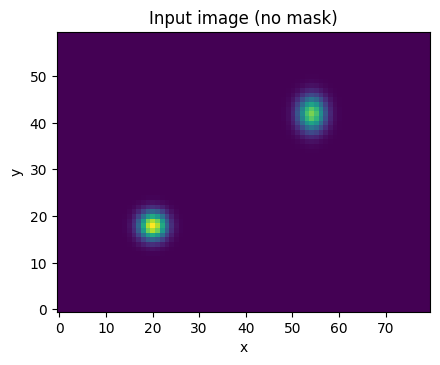

x0 20.0
y0 18.0
success True


In [21]:
xda = synthetic_scene()
show_image_and_mask(xda, title="Input image (no mask)")

ds_nomask = fit_multi_gaussian2d(
    xda,
    n_components=1,
    coord_type="pixel",
    return_model=False,
    return_residual=False,
)

# pick the first (and only) component explicitly
x0 = single_float(ds_nomask["x0_pixel"].sel(component=0))
y0 = single_float(ds_nomask["y0_pixel"].sel(component=0))
ok = bool(single_float(ds_nomask["success"]))

print("x0", round(x0,3))
print("y0", round(y0, 3))
print("success", ok)

## Boolean mask: exclude a bright region
### We’ll exclude the brightest peak using a `(y, x)` boolean mask so the fit targets the other peak.


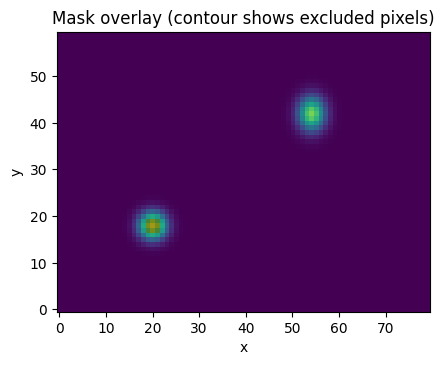

x0 54.0
y0 42.0
success True


In [22]:
ny, nx = xda.sizes["y"], xda.sizes["x"]
mask = np.ones((ny, nx), dtype=bool)
mask[17:20, 19:22] = False  # exclude the brighter peak around (x≈20, y≈18)

show_image_and_mask(xda, xr.DataArray(mask, dims=("y", "x")), title="Mask overlay (contour shows excluded pixels)")

ds_boolmask = fit_multi_gaussian2d(
    xda,
    n_components=1,
    mask=mask,            # <- boolean mask
    coord_type="pixel",
    return_model=False,
    return_residual=False,
)

x0 = single_float(ds_boolmask["x0_pixel"].sel(component=0))
y0 = single_float(ds_boolmask["y0_pixel"].sel(component=0))
ok = bool(single_float(ds_nomask["success"]))

print("x0", round(x0,3))
print("y0", round(y0, 3))
print("success", ok)

## OTF string mask (delegates to `selection.select_mask`)
### `mask` also accepts a **string** that your `selection.select_mask(data, spec)` can parse.

### Tip: inspect your project’s supported syntax:

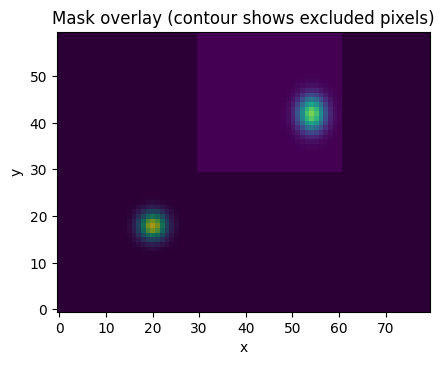

x0 54.0
y0 42.0
success True


In [23]:
# mask the brighter component.
otf_mask = "box[[30pix,30pix],[60pix,60pix]]"

z = select_mask(xda, otf_mask)

show_image_and_mask(xda, otf_mask, title="Mask overlay (contour shows excluded pixels)")

ds_otfmask = fit_multi_gaussian2d(
    xda,
    n_components=1,
    mask=otf_mask,            # <- boolean mask
    coord_type="pixel",
    return_model=False,
    return_residual=False,
)

x0 = single_float(ds_otfmask["x0_pixel"].sel(component=0))
y0 = single_float(ds_otfmask["y0_pixel"].sel(component=0))
ok = bool(single_float(ds_nomask["success"]))

print("x0", round(x0,3))
print("y0", round(y0, 3))
print("success", ok)

## Broadcast a `(y, x)` mask across a stacked cube
### 2-D mask is broadcast across any leading dims (e.g., `time`).

In [24]:
# Build a small time-cube by repeating the image and adding tiny per-frame noise
cube = xr.concat([xda + 0.05*np.random.randn(*xda.shape) for _ in range(3)], dim="time")

# Reuse the same 2-D mask defined earlier; it should broadcast across 'time'
ds_broadcast = fit_multi_gaussian2d(
    cube,
    n_components=1,
    mask=mask,            # <- 2-D mask broadcasts across 'time'
    coord_type="pixel",
    return_model=False,
    return_residual=False,
)
# Show centers across time
np.vstack([
    np.round(ds_broadcast["x0_pixel"].values, 3),
    np.round(ds_broadcast["y0_pixel"].values, 3)
])

print("Time     x0           y0     success")
for time in range(3):
    print(
        f"{time}      {round(ds_broadcast["x0_pixel"].isel(time=time).item(), 3): .3f}"
        + f"      {round(ds_broadcast["y0_pixel"].isel(time=time).item(), 3): .3f}"
        + f"   {ds_broadcast["success"].isel(time=time).item()}"
    )

Time     x0           y0     success
0       53.994       42.001   True
1       54.000       41.992   True
2       53.999       41.999   True


## Combine mask with thresholds
### The final effective mask is `mask ∧ (data >= min_threshold) ∧ (data <= max_threshold)`.
### Let’s keep only pixels ≥ 1.0 **and** apply our boolean mask.

In [25]:
ds_mask_thresh = fit_multi_gaussian2d(
    xda,
    n_components=1,
    mask=mask,
    min_threshold=1.0,    # ← combine with mask
    coord_type="pixel",
    return_model=False,
    return_residual=False,
)

x0 = ds_boolmask["x0_pixel"].sel(component=0).compute().item()
y0 = ds_boolmask["y0_pixel"].sel(component=0).compute().item()
ok = bool(ds_boolmask["success"].compute().item())
print("x0", round(x0,4))
print("y0", round(y0, 4))
print("success", ok)

x0 54.0
y0 42.0
success True


## Error handling: empty effective mask
### If masking ∧ thresholding removes all usable pixels, a `ValueError` is raised.

In [27]:
try:
    _ = fit_multi_gaussian2d(
        xda*0.0,             # no signal
        n_components=1,
        mask=~np.zeros_like(xda, dtype=bool),  # or use min_threshold > max value
        min_threshold=1e3,
        coord_type="pixel",
        return_model=False,
        return_residual=False,
    )
except ValueError as e:
    print("Expected failure:", repr(e))

Expected failure: ValueError('Thresholding removed all pixels (empty mask); adjust min/max thresholds.')


# TODO Rewrite
Below here needs rewriting. As is things are likely to break.

## 5) Bounds (and fixing parameters)
- Dict mapping names → `(low, high)` **or** per-component list of tuples.
- To **fix** a value, use equal bounds `(v, v)`.

bounds_all = {"amplitude": (0.4, 1.5)}
bounds_per = {"sigma_x": [(2.5, 3.5), (4.0, 6.0)]}

ds_bounds_all = fit_multi_gaussian2d(img, n_components=2, initial_guesses=init_arr, bounds=bounds_all)
ds_bounds_per = fit_multi_gaussian2d(img, n_components=2, initial_guesses=init_arr, bounds=bounds_per)

ds_fix_offset = fit_multi_gaussian2d(
    img, n_components=2, initial_guesses=init_arr, bounds={"offset": (0.12, 0.12)}
)
float(ds_fix_offset.offset)

## 6) Return model and residual
- `return_model=True` → `ds["model"]`
- `return_residual=True` → `ds["residual"] = data - model`

ds_planes = fit_multi_gaussian2d(
    img, n_components=2, initial_guesses=init_arr, return_model=True, return_residual=True
)
ds_planes["model"], ds_planes["residual"]

## 7) Angle conventions: `"math"`, `"pa"`, `"auto"`
- `"math"`: θ from +x → +y (CCW) in data axes.
- `"pa"`: position angle from +y → +x.
- `"auto"`: detect left-handed axes (descending/ascending) and use PA; else math.
Inputs interpret `theta` per `angle`, outputs reported in the same convention.

# Fit with PA conventions; seeds given in PA
pa_init = [{
    "amp": 1.0, "x0": 42.0, "y0": 60.0, "sigma_x": 3.0, "sigma_y": 2.2,
    "theta": float(np.arctan2(np.cos(0.5), np.sin(0.5)))
}]
ds_pa = fit_multi_gaussian2d(img, n_components=1, initial_guesses=pa_init, angle="pa")
float(ds_pa.theta)

# AUTO: make a left-handed grid by flipping 'y' coords; AUTO chooses PA here
img_desc_y = img.assign_coords(y=img.y.values[::-1])
ds_auto = fit_multi_gaussian2d(img_desc_y, n_components=1, initial_guesses=pa_init, angle="auto")
float(ds_auto.theta)

## 8) Vectorized fitting over extra dims
N-D inputs are fit per-plane across all leading dims; specify plane dims with `dims=("x","y")` if needed.

planes = [img + 0.01 * rng.normal(size=img.shape) for _ in range(3)]
cube = xr.concat(planes, dim="time")  # dims: ('time','y','x')

ds_cube = fit_multi_gaussian2d(cube, n_components=2, initial_guesses=init_arr, dims=("x", "y"))
ds_cube

## 9) Dask-backed arrays
Accepts Dask arrays and parallelizes via `xarray.apply_ufunc(dask="parallelized")`.

cube_np = np.stack([(img + 0.01 * rng.normal(size=img.shape)).values for _ in range(4)], axis=0)
cube_da = xr.DataArray(da.from_array(cube_np, chunks=(2, img.shape[0], img.shape[1])), dims=("time", "y", "x"))

ds_dask = fit_multi_gaussian2d(cube_da, n_components=2, initial_guesses=init_arr, dims=("x", "y"))
float(ds_dask["amplitude"].mean().compute())

## 10) World coordinates of centroids
If both fit axes have 1-D numeric coords, results include `x_world(component)` and `y_world(component)`.

("x_world" in ds_basic and "y_world" in ds_basic), ds_basic.get("x_world"), ds_basic.get("y_world")

## 11) Error handling & tips
- `n_components` ≥ 1.
- N-D arrays without `(\"x\",\"y\")` dims: pass `dims=(x_dim, y_dim)`.
- Initial guesses length/shape must match `n_components`.
- Bounds: per-component list must be length N; to fix a value, use `(v, v)`.
- Performance: reasonable seeds & tight bounds; adjust `max_nfev`; with Dask, tune chunking/scheduler.